In [1]:
import os, json, math, shutil
import numpy as np
import tensorflow as tf
!sudo apt install graphviz -y

# environment variables used by bash cells
PROJECT=!(gcloud config get-value project)
PROJECT=PROJECT[0]

REGION = 'us-west1'
BUCKET='{}-dsongcp'.format(PROJECT)
os.environ['ENDPOINT_NAME'] = 'flights'

os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TF_VERSION']='2-' + tf.__version__[2:4]

2024-04-07 15:06:53.480948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 15:07:31.328164: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/opt/conda/lib
2024-04-07 15:07:31.329526: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-liberation libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin libgvc6
  libgvpr2 liblab-gamut1 libpathplan4
Suggested packages:
  gsfonts graphviz-doc
The following NEW packages will be installed:
  fonts-liberation graphviz libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin
  libgvc6 libgvpr2 liblab-gamut1 libpathplan4
0 upgraded, 11 newly installed, 0 to remove and 2 not upgraded.
Need to get 3032 kB of archives.
After this operation, 11.5 MB of additional disk space will be used.
Get:1 https://deb.debian.org/debian bullseye/main amd64 fonts-liberation all 1:1.07.4-11 [828 kB]
Get:2 https://deb.debian.org/debian bullseye/main amd64 libann0 amd64 1.1.2+doc-7 [25.3 kB]
Get:3 https://deb.debian.org/debian bullseye/main amd64 libcdt5 amd64 2.42.2-5 [62.2 kB]
Get:4 https://deb.debian.org/debian bullseye/main amd64 libcgraph6 amd64 2.

Create training dataset flights_train_data for model training:

In [2]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_train_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND
  f.DIVERTED = False AND
  is_train_day = 'True'

Query is running:   0%|          |

""


Create the evaluation dataset flights_eval_data for model evaluation:

In [3]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_eval_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND
  f.DIVERTED = False AND
  is_train_day = 'False'

Query is running:   0%|          |

""


Create the full dataset flights_all_data using the following code:

In [4]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_all_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon,
  IF (is_train_day = 'True',
      IF(ABS(MOD(FARM_FINGERPRINT(CAST(f.FL_DATE AS STRING)), 100)) < 60, 'TRAIN', 'VALIDATE'),
      'TEST') AS data_split
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND
  f.DIVERTED = False

Query is running:   0%|          |

""


Export the training, validation, and full datasets to CSV file format to the Google Cloud Storage bucket

In [5]:
%%bash
PROJECT=$(gcloud config get-value project)
for dataset in "train" "eval" "all"; do
  TABLE=dsongcp.flights_${dataset}_data
  CSV=gs://${BUCKET}/ch9/data/${dataset}.csv
  echo "Exporting ${TABLE} to ${CSV} and deleting table"
  bq --project_id=${PROJECT} extract --destination_format=CSV $TABLE $CSV
  bq --project_id=${PROJECT} rm -f $TABLE
done

Exporting dsongcp.flights_train_data to gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/data/train.csv and deleting table


/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
Waiting on bqjob_r3303143c3796dbdf_0000018eb91b8684_1 ... (65s) Current status: DONE   
/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Exporting dsongcp.flights_eval_data to gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/data/eval.csv and deleting table


/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
Waiting on bqjob_r579b9001cd7e808a_0000018eb91c96d6_1 ... (34s) Current status: DONE   
/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Exporting dsongcp.flights_all_data to gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/data/all.csv and deleting table


/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
Waiting on bqjob_r57dda4708126f391_0000018eb91d2cd3_1 ... (109s) Current status: DONE   
/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


List exported objects to Google Cloud Storage bucket

In [8]:
!gsutil ls -lh gs://{BUCKET}/ch9/data

445.01 MiB  2024-04-07T13:57:18Z  gs://qwiklabs-gcp-03-2fffc1dadae2-dsongcp/ch9/data/all.csv
115.19 MiB  2024-04-07T13:55:33Z  gs://qwiklabs-gcp-03-2fffc1dadae2-dsongcp/ch9/data/eval.csv
296.96 MiB  2024-04-07T13:54:59Z  gs://qwiklabs-gcp-03-2fffc1dadae2-dsongcp/ch9/data/train.csv
TOTAL: 3 objects, 898801258 bytes (857.16 MiB)


In [6]:
# For development purposes, train for a few epochs. That's why the NUM_EXAMPLES is so low
DEVELOP_MODE = True
NUM_EXAMPLES = 5000*1000

In [7]:
# Assign your training and validation data URI to training_data_uri and validation_data_uri respectively
training_data_uri = 'gs://{}/ch9/data/train*'.format(BUCKET)
validation_data_uri = 'gs://{}/ch9/data/eval*'.format(BUCKET)

In [8]:
# Set up Model Parameters
NBUCKETS = 5
NEMBEDS = 3
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

In [9]:
# read the CSV files from Google Cloud Storage into TensorFlow
if DEVELOP_MODE:
    train_df = tf.data.experimental.make_csv_dataset(training_data_uri, batch_size=5)
    for n, data in enumerate(train_df):
        numpy_data = {k: v.numpy() for k, v in data.items()}
        print(n, numpy_data)
        if n==1: break

2024-04-07 15:16:40.784370: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/opt/conda/lib
2024-04-07 15:16:40.784458: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-07 15:16:40.784498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240407-075511): /proc/driver/nvidia/version does not exist
2024-04-07 15:16:40.863806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebu

0 {'ontime': array([1, 1, 1, 1, 1], dtype=int32), 'dep_delay': array([ -8,  -6,   1, -13,   0], dtype=int32), 'taxi_out': array([20, 16,  9, 13, 31], dtype=int32), 'distance': array([190, 284, 991, 421, 282], dtype=int32), 'origin': array([b'IAH', b'DTW', b'DEN', b'PSP', b'DFW'], dtype=object), 'dest': array([b'AEX', b'CIU', b'PDX', b'SFO', b'LBB'], dtype=object), 'dep_hour': array([15, 17,  3, 14, 13], dtype=int32), 'is_weekday': array([1, 1, 1, 0, 1], dtype=int32), 'carrier': array([b'EV', b'OO', b'F9', b'AS', b'MQ'], dtype=object), 'dep_airport_lat': array([29.984444, 42.2125  , 39.861668, 33.829723, 32.89722 ],
      dtype=float32), 'dep_airport_lon': array([ -95.34139,  -83.35333, -104.67306, -116.50667,  -97.03778],
      dtype=float32), 'arr_airport_lat': array([31.3275  , 46.25083 , 45.58861 , 37.61889 , 33.663612],
      dtype=float32), 'arr_airport_lon': array([ -92.548615,  -84.4725  , -122.59695 , -122.375   , -101.82056 ],
      dtype=float32)}
1 {'ontime': array([1, 1, 1,

In [10]:
# util functions

def features_and_labels(features):
  label = features.pop('ontime')
  return features, label

def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
  dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, num_epochs=1)
  dataset = dataset.map(features_and_labels)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(batch_size*10)
    dataset = dataset.repeat()
  dataset = dataset.prefetch(1)
  if truncate is not None:
    dataset = dataset.take(truncate)
  return dataset

In [15]:
if DEVELOP_MODE:
    print("Checking input pipeline")
    one_item = read_dataset(training_data_uri, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

Checking input pipeline
[(OrderedDict([('dep_delay', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-5, 27], dtype=int32)>), ('taxi_out', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([12, 10], dtype=int32)>), ('distance', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1448,  948], dtype=int32)>), ('origin', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'SEA', b'SJC'], dtype=object)>), ('dest', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'ANC', b'DEN'], dtype=object)>), ('dep_hour', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([14, 21], dtype=int32)>), ('is_weekday', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>), ('carrier', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'AS', b'WN'], dtype=object)>), ('dep_airport_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([47.45    , 37.362778], dtype=float32)>), ('dep_airport_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-122.31167, -121.92917], dtype=float32)>), ('a

In [11]:
# keep the real-valued columns separate from the sparse (or string) columns
import tensorflow as tf

real = {
    colname : tf.feature_column.numeric_column(colname)
          for colname in
            (
                'dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
                'dep_airport_lat,dep_airport_lon,' +
                'arr_airport_lat,arr_airport_lon'
            ).split(',')
}
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000),
}

In [12]:
# Input layers map 1:1 to the input features and their types, 
# create an input layer for each of these columns, specifying the right data type (either a float or a string)
inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
          for colname in sparse.keys()
})

Bucketing

Real-valued columns whose precision is overkill (thus, likely to cause overfitting) can be discretized and made into categorical columns. For example, if you have a column for the age of the aircraft, you might discretize into just three bins—less than 5 years old, 5 to 20 years old, and more than 20 years old. Use the discretization shortcut: you can discretize the latitudes and longitudes and cross the buckets—this results in breaking up the country into grids and yield the grid point into which a specific latitude and longitude falls. OKAY!

In [13]:
# discretize the latitudes and longitudes and cross the buckets—this results in breaking up the country into grids 
# and yield the grid point into which a specific latitude and longitude falls.

# np.linspace(20.0, 50.0, 5).tolist() -> [20.0, 27.5, 35.0, 42.5, 50.0]
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets)
          for key in ['dep_airport_lat', 'arr_airport_lat']
})
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets)
          for key in ['dep_airport_lon', 'arr_airport_lon']
})

# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column(
    [disc['d_dep_airport_lat'], disc['d_dep_airport_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column(
    [disc['d_arr_airport_lat'], disc['d_arr_airport_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)

# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, NEMBEDS)
          for colname, col in sparse.items()
}
real.update(embed)

# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}

if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['carrier', 'origin', 'dest', 'dep_loc', 'arr_loc', 'dep_arr'])
dict_keys(['dep_delay', 'taxi_out', 'distance', 'dep_hour', 'is_weekday', 'dep_airport_lat', 'dep_airport_lon', 'arr_airport_lat', 'arr_airport_lon', 'embed_carrier', 'embed_origin', 'embed_dest', 'embed_dep_loc', 'embed_arr_loc', 'embed_dep_arr'])


In [14]:
# create save checkpoint
output_dir='gs://{}/ch9/trained_model'.format(BUCKET)
os.environ['OUTDIR'] = output_dir  # needed for deployment
print('Writing trained model to {}'.format(output_dir))

Writing trained model to gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model


In [21]:
# delete any other model checkpoints
!gsutil -m rm -rf $OUTDIR

Removing gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/#1712503074556376...
Removing gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/checkpoints/#1712503074822897...
Removing gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/checkpoints/checkpoint#1712503244861488...
Removing gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/checkpoints/flights.cpt.data-00000-of-00001#1712503244183874...
Removing gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/checkpoints/flights.cpt.index#1712503244368289...
/ [5/5 objects] 100% Done                                                       
Operation completed over 5 objects.                                              


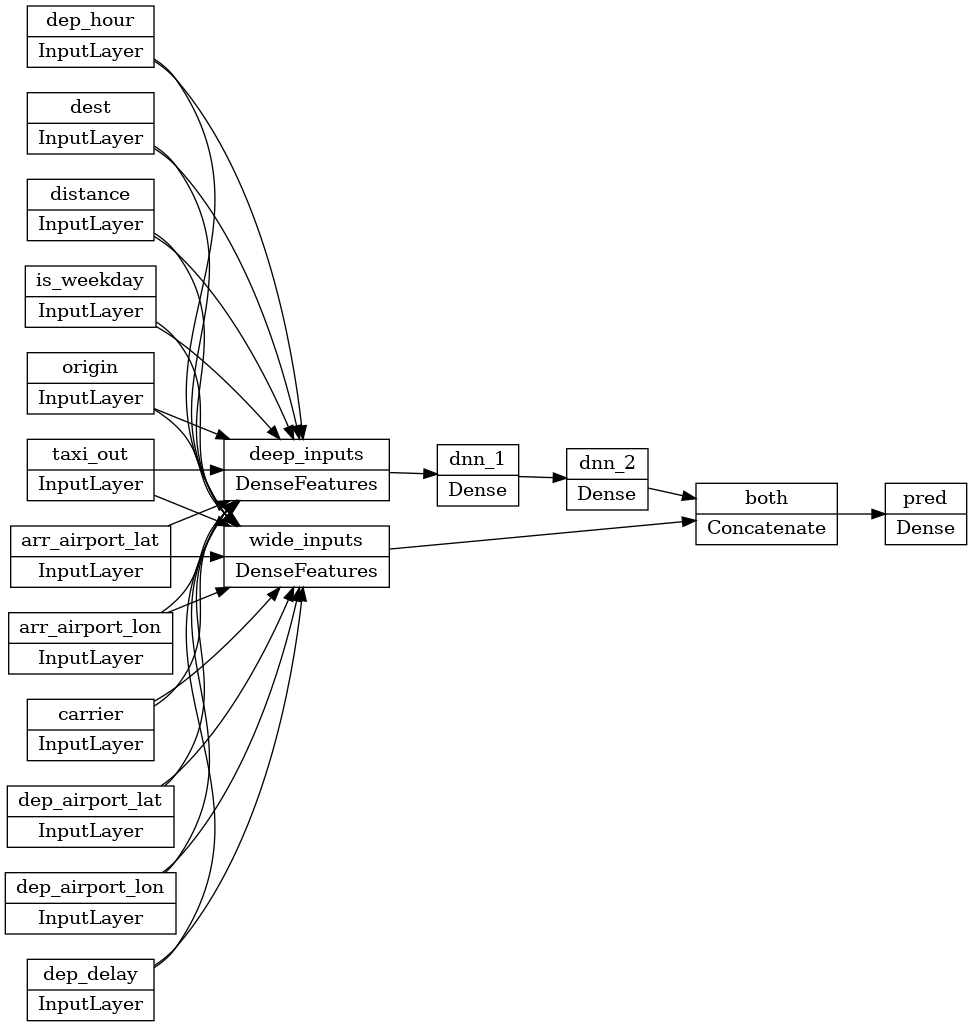

In [16]:
# wide and deep classifier
# Build a wide-and-deep model

def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

In [22]:
# train and evaluate model

# training and evaluation dataset
train_batch_size = TRAIN_BATCH_SIZE
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 3
    epochs = 2
    num_eval_examples = eval_batch_size*10
else:
    eval_batch_size = 100
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
    num_eval_examples = eval_batch_size * 100
train_dataset = read_dataset(training_data_uri, train_batch_size)
eval_dataset = read_dataset(validation_data_uri, eval_batch_size, tf.estimator.ModeKeys.EVAL, num_eval_examples)

checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_dataset,
                    validation_data=eval_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Epoch 1/2
1/3 [=========>....................] - ETA: 3s - loss: 1.4210 - accuracy: 0.7500
Epoch 1: saving model to gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 11s 4s/step - loss: 1.2922 - accuracy: 0.7812 - val_loss: 1.6679 - val_accuracy: 0.8186
Epoch 2/2
1/3 [=========>....................] - ETA: 0s - loss: 2.5297 - accuracy: 0.7188
Epoch 2: saving model to gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 8s 4s/step - loss: 2.0868 - accuracy: 0.8125 - val_loss: 1.7434 - val_accuracy: 0.8183


In [ ]:
# Visualize the model loss and model accuracy

import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

In [23]:
# export model 

import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)

Exporting to gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/export/flights_20240407-152517


INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/export/flights_20240407-152517/assets


INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/export/flights_20240407-152517/assets


Deploy on vertex AI

In [24]:
%%bash
# note TF_VERSION and ENDPOINT_NAME set in 1st cell
# TF_VERSION=2-6
# ENDPOINT_NAME=flights

TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH

# create the model endpoint for deploying the model
if [[ $(gcloud ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi

ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"


# delete any existing models with this name
for MODEL_ID in $(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done


# create the model using the parameters docker conatiner image and artifact uri
gcloud ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH
MODEL_ID=$(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"


# deploy the model to the endpoint
gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=e2-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/export/flights_20240407-152517/


Using endpoint [https://us-west1-aiplatform.googleapis.com/]


Creating Endpoint for flights-20240407-152535


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [5989957928705064960]...
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.
Created Vertex AI endpoint: projects/836326919103/locations/us-west1/endpoints/3326194197836333056.
Using endpoint [https://us-w

ENDPOINT_ID=3326194197836333056


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [1216142323692339200]...
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.
Using endpoint [https://us-west1-aiplatform.googleapis.com/]


MODEL_ID=2399952408458297344


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [303741186684747776]...
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Create a test input file

In [25]:
%%writefile example_input.json
{"instances": [
  {"dep_hour": 2, "is_weekday": 1, "dep_delay": 40, "taxi_out": 17, "distance": 41, "carrier": "AS", "dep_airport_lat": 58.42527778, "dep_airport_lon": -135.7075, "arr_airport_lat": 58.35472222, "arr_airport_lon": -134.57472222, "origin": "GST", "dest": "JNU"},
  {"dep_hour": 22, "is_weekday": 0, "dep_delay": -7, "taxi_out": 7, "distance": 201, "carrier": "HA", "dep_airport_lat": 21.97611111, "dep_airport_lon": -159.33888889, "arr_airport_lat": 20.89861111, "arr_airport_lon": -156.43055556, "origin": "LIH", "dest": "OGG"}
]}

Writing example_input.json


Make a prediction from the model endpoint

In [26]:
%%bash
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo $ENDPOINT_ID
gcloud ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=example_input.json

Using endpoint [https://us-west1-aiplatform.googleapis.com/]


3326194197836333056


Using endpoint [https://us-west1-prediction-aiplatform.googleapis.com/]


[[0.940806031], [0.981082857]]


how client programs can invoke the model that you deployed

In [27]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})

curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:predict"

Using endpoint [https://us-west1-aiplatform.googleapis.com/]
curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   831    0   288  100   543   1040   1960 --:--:-- --:--:-- --:--:--  3010


{
  "predictions": [
    [
      0.940806031
    ],
    [
      0.981082857
    ]
  ],
  "deployedModelId": "5933883935200116736",
  "model": "projects/836326919103/locations/us-west1/models/2399952408458297344",
  "modelDisplayName": "flights-20240407-152535",
  "modelVersionId": "1"
}


Model explainability is one of the most important problems in machine learning. It's a broad concept of analyzing and understanding the results provided by machine learning models. Explainability in machine learning means you can explain what happens in your model from input to output. It makes models transparent and solves the black box problem. Explainable AI (XAI) is the more formal way to describe this.

In [28]:
%%bash
model_dir=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $model_dir
saved_model_cli show --tag_set serve --signature_def serving_default --dir $model_dir

gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/export/flights_20240407-152517/


2024-04-07 15:49:25.270385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 15:49:26.514539: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/opt/conda/lib
2024-04-07 15:49:26.514658: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl

The given SavedModel SignatureDef contains the following input(s):
  inputs['arr_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lat:0
  inputs['arr_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lon:0
  inputs['carrier'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_carrier:0
  inputs['dep_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lat:0
  inputs['dep_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lon:0
  inputs['dep_delay'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_delay:0
  inputs['dep_hour'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_hour:0
  inputs['dest'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: se

In [29]:
# !cat explanation-metadata.json Create a JSON file explanation-metadata.json that contains the metadata describing the Model's input and output for explanation.
# Here, you use sampled-shapley method used for explanation:
cols = ('dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
        'dep_airport_lat,dep_airport_lon,' +
        'arr_airport_lat,arr_airport_lon,' +
        'carrier,origin,dest')
inputs = {x: {"inputTensorName": "{}".format(x)}
        for x in cols.split(',')}
expl = {
    "inputs": inputs,
    "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}
print(expl)
with open('explanation-metadata.json', 'w') as ofp:
    json.dump(expl, ofp, indent=2)

{'inputs': {'dep_delay': {'inputTensorName': 'dep_delay'}, 'taxi_out': {'inputTensorName': 'taxi_out'}, 'distance': {'inputTensorName': 'distance'}, 'dep_hour': {'inputTensorName': 'dep_hour'}, 'is_weekday': {'inputTensorName': 'is_weekday'}, 'dep_airport_lat': {'inputTensorName': 'dep_airport_lat'}, 'dep_airport_lon': {'inputTensorName': 'dep_airport_lon'}, 'arr_airport_lat': {'inputTensorName': 'arr_airport_lat'}, 'arr_airport_lon': {'inputTensorName': 'arr_airport_lon'}, 'carrier': {'inputTensorName': 'carrier'}, 'origin': {'inputTensorName': 'origin'}, 'dest': {'inputTensorName': 'dest'}}, 'outputs': {'pred': {'outputTensorName': 'pred'}}}


In [30]:
!cat explanation-metadata.json

{
  "inputs": {
    "dep_delay": {
      "inputTensorName": "dep_delay"
    },
    "taxi_out": {
      "inputTensorName": "taxi_out"
    },
    "distance": {
      "inputTensorName": "distance"
    },
    "dep_hour": {
      "inputTensorName": "dep_hour"
    },
    "is_weekday": {
      "inputTensorName": "is_weekday"
    },
    "dep_airport_lat": {
      "inputTensorName": "dep_airport_lat"
    },
    "dep_airport_lon": {
      "inputTensorName": "dep_airport_lon"
    },
    "arr_airport_lat": {
      "inputTensorName": "arr_airport_lat"
    },
    "arr_airport_lon": {
      "inputTensorName": "arr_airport_lon"
    },
    "carrier": {
      "inputTensorName": "carrier"
    },
    "origin": {
      "inputTensorName": "origin"
    },
    "dest": {
      "inputTensorName": "dest"
    }
  },
  "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}

Create the model endpoint flights_xai, upload the model, and deploy it at the model endpoint using the following code:

In [31]:
%%bash
# note ENDPOINT_NAME is being changed

ENDPOINT_NAME=flights_xai

TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH

# create the model endpoint for deploying the model
if [[ $(gcloud ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    # create model endpoint
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi

ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"


# delete any existing models with this name
for MODEL_ID in $(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done


# upload the model using the parameters docker conatiner image, artifact URI, explanation method,
# explanation path count and explanation metadata JSON file `explanation-metadata.json`.
# Here, you keep number of feature permutations to `10` when approximating the Shapley values for explanation.
gcloud ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH \
     --explanation-method=sampled-shapley --explanation-path-count=10 --explanation-metadata-file=explanation-metadata.json
MODEL_ID=$(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"


# deploy the model to the endpoint
gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=e2-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-00-296140180bbf-dsongcp/ch9/trained_model/export/flights_20240407-152517/


Using endpoint [https://us-west1-aiplatform.googleapis.com/]


Creating Endpoint for flights_xai-20240407-155034


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [2945524580602609664]...
......................done.
Created Vertex AI endpoint: projects/836326919103/locations/us-west1/endpoints/178178058304356352.
Using endpoint [https://us-west1-aiplatform.googleapis.com/]


ENDPOINT_ID=178178058304356352


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [6800605861631754240]...
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

MODEL_ID=596260757696413696


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [8003066962139676672]...
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Here’s how client programs can invoke the model you deployed. Assume that they have the input data in a JSON file called example_input.json. Now, send an HTTP POST request and you will get the result back as JSON.

In [32]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_NAME=flights_xai
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})

curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:explain"

Using endpoint [https://us-west1-aiplatform.googleapis.com/]
curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2557    0  2014  100   543    942    254  0:00:02  0:00:02 --:--:--  1197


{
  "explanations": [
    {
      "attributions": [
        {
          "baselineOutputValue": 0.52251625061035156,
          "instanceOutputValue": 0.94080603122711182,
          "featureAttributions": {
            "distance": 0.042721176147460939,
            "dest": -0.0051912605762481686,
            "dep_delay": -0.018220239877700811,
            "taxi_out": -0.01223649382591247,
            "carrier": -0.0029786586761474609,
            "dep_hour": 0.0021832585334777832,
            "arr_airport_lon": 0.13701033890247341,
            "origin": -0.0064539998769760128,
            "dep_airport_lat": 0.075917685031890864,
            "arr_airport_lat": -0.057737642526626588,
            "is_weekday": 0.00025331974029541021,
            "dep_airport_lon": 0.26302229762077328
          },
          "outputIndex": [
            0
          ],
          "approximationError": 0.00771710463587483,
          "outputName": "pred"
        }
      ]
    },
    {
      "attributions": [
     